# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Image Pipeline

Import the python file containing object tracking pipeline. This file contains all of the classes and helper functions. All parameter choices are made in this document.

In [1]:
%load_ext autoreload
%autoreload 2

import time

# Import project packages
from imganalyser import ImageAnalyser
from carsearch import GridSearch
from carclassifier import Classifier
from datahandler import TrainingData
from utilityfun import *
from searchfilter import SearchFilter

In [2]:
%matplotlib inline

The pipeline consists of an **`ImageAnalyser`** object, that is responsible for extracting the features of interest so that these can then be used by a **`Classifier`** object.  

The **`Classifier`** is an abstraction, so that a new classification can easily be tested without having to change much in the code.  

The **`TrainingData`** object manages the training data, including importing and extracting feature data as well as providing shuffled test and training data.

Once a **`Classifier`** has been trained with the training data, a **`GridSearch`** object can then be used to perform a sliding window search on images of any size, that may contain multiple cars.

The search hits that are registered by the **`GridSearch`** are then processed by the **`SearchFilter`** object.  This is used to consolidate duplicate hits and filter out false positives.

Finally, **`utilityfun`** contains a variety of utility and heler functions for example to overlay annotations on images or to compare two images in a side-by-side plot.

## The Car Classifier

The first step in the pipeline is to train a car classifier that is then used to identify cars in the subsequent sliding window search.

The feature set for the classifier consists of a histogram of oriented gradients (HOG), which essentially describes the shape of an image in a reduced feature space, by extracting the dominant gradient direction in so-called pixel cells which subdivide the image. In addition to the gradients, each cell's color histogram and spatial colour distribution are also recorded and used as a training features.

### Histogram of Oriented Gradients (HOG)

For this stage, we need to create an image analyser object, which takes in the relevant HOG feature extraction, spatial colour bin and histogram parameters.

To improve the performance for the upcoming sliding window search, the HOG features are extracted once for an image and can then be requested for a given window of interest. This is significantly more computationally efficient.

At this stage we also set the colourspace in which we would like to work. It was found that the colourspaces that separate chroma from luminance performed best. It is expected that this had something to do with the insensitivity of the colour values to brightness. This is why the YCrCb colourspace was chosen for the pipeline.

In [3]:
cell_size = 8 #px
hog_params = {'orientations': 9,
              'pix_per_cell': cell_size,
              'cell_per_block': 2,
              'visualise': True}
histogram_bins = 32
colorspace = 'YCrCb'
spatial_size = (32, 32)

analyser = ImageAnalyser(hog_params, spatial_size=spatial_size, histogram_bins=histogram_bins, colorspace=colorspace)

After some experimentation with the various HOG parameters, the final choice for the orientation, remained close to the recommendation of 9 since fewer orientations reduced the accuracy of the classifier and more did not appear to have a significant benefit.  

Furthermore, the pixels per cell were chosen at 8.  For practical purposes with the sliding window search the value had to be base 2 for easy scaling. In addition to this, a higher value of 16 led to insufficient resolution and a lower value of 4 increased the computational cost too significantly.

We now supply the **`analyser`** with an image file, this automatically triggers the feature extraction routines.

In [4]:
preview = import_image('./test_images/image0120.png')
analyser(preview)

Visualise the result of the HOG feature extraction:

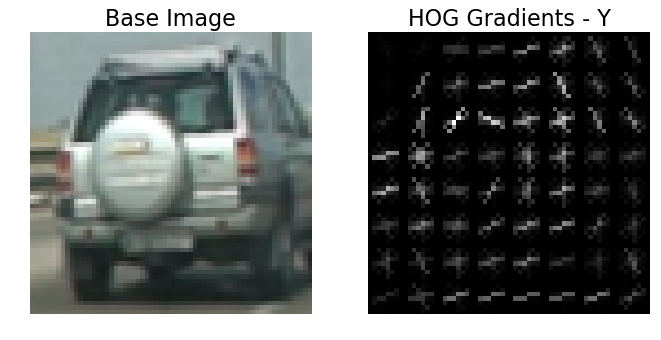

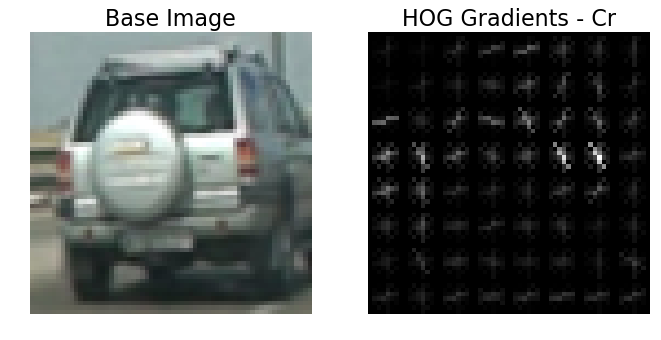

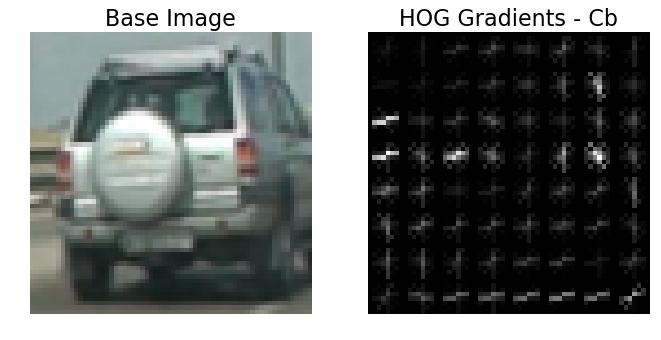

In [5]:
base_image = analyser.get_image()
channels = ('Y', 'Cr', 'Cb')

for i, image in enumerate(analyser.get_hog_visualisation()):
    compare_images(base_image, image, ('Base Image', 'HOG Gradients - ' + channels[i]))

The HOG was first determined based on the grayscale image alone, but it was found that taking the gradients of each channel individually brought substantial accuracy improvements during classification. Here we can clearly identify the effect of the red taillights. This approach also increases the relative weight of the HOG features on the classification with respect to the spatial and histogram features.

### Spatial Colour Bins and Histograms

For the colour features, the image is resized to a coarse representation and then each pixel channel is split into bins.

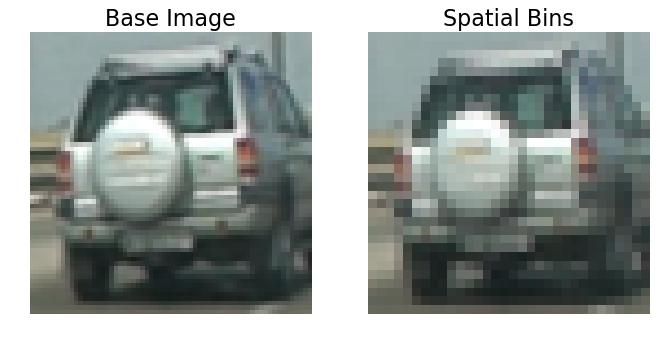

In [6]:
compare_images(base_image, analyser.get_spatial_visualisation(), ('Base Image', 'Spatial Bins'))

Finally, the histograms for each channel of the image are also recorded as features:

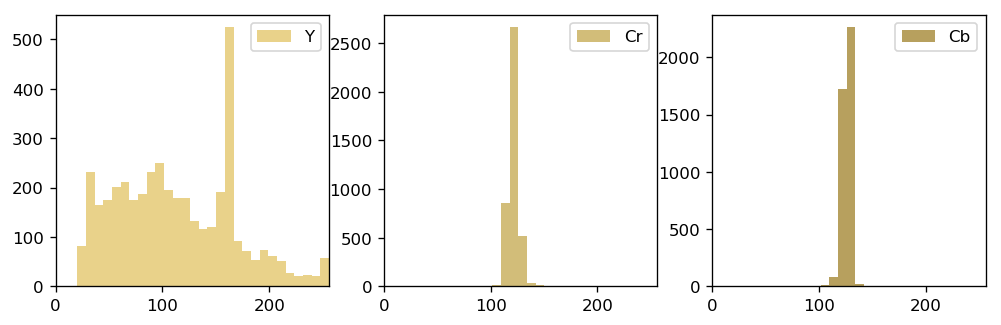

In [7]:
analyser.get_histogram_visualisation()

### Training the Classifier

Import the training data.

In [8]:
training_set = TrainingData('./training_data/')

Training data set imported.


A sample of the training images labeled as vehicles:

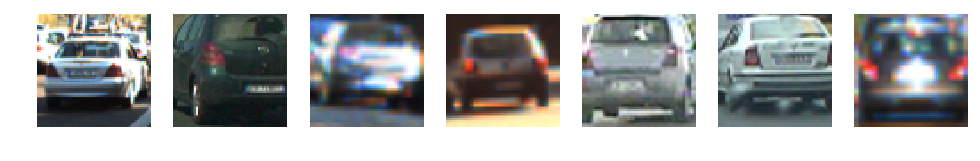

In [9]:
plt.subplots(1, 7, figsize=(12, 5), dpi=100)
for i, image in enumerate(training_set.get_random_training_images(label='vehicles', number=7)):
    plt.subplot(1, 7, i+1)
    plot_image(image)

Here we can see the wide variety of images in the set. Even though the images are resized to the same resolution, there is a clear variance in original resolution. There are overexposed and underexposed images. Sometimes the car is cropped, while in other cases it does not fill the frame.

A sample of the training images labeled as non-vehicles:

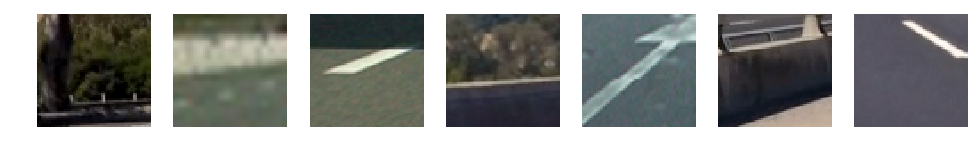

In [10]:
plt.subplots(1, 7, figsize=(12, 5), dpi=100)
for i, image in enumerate(training_set.get_random_training_images(label='non-vehicles', number=7)):
    plt.subplot(1, 7, i+1)
    plot_image(image)

Extract the desired training features from the data set. For this, the training set object makes use of an ImageFrame object to extract the features as seen above. The "visualise" option in the HOG parameters is switched off, since this is computationally expensive.

In [11]:
hog_params['visualise'] = False
analyser = ImageAnalyser(hog_params, spatial_size=(32, 32), histogram_bins=32, colorspace='YCrCb')

In [12]:
training_set.extract_features(analyser, hog_features=True)

Extracted feature vectors from images labelled as non-vehicles in 50.96537804603577 sec.
Extracted feature vectors from images labelled as vehicles in 50.82914209365845 sec.


Get training and test set. The `training_set` object shuffles and splits the training data into test and training sets. The default split is 75% training and 25% testing. No effort was made to separate time series data although this could be a potential improvement.

In [13]:
(features_train, features_test, labels_train, labels_test) = training_set.get_data()

Set up a linear support vector machine classifier.  Using a non-linear SVM with radial basis functions was found to be more accurate, but also far more computationally expensive.

In [14]:
params = {'C': 1.0}
classifier = Classifier.svm_linear(params)

Normalising the features for fitting and inference:

In [15]:
classifier.fit_feature_scaler(features_train)

Fit the classifier to the training data:

In [16]:
classifier.train(features_train, labels_train, features_test, labels_test)

Classifier test accuracy =  0.9885 (took 0.72 seconds on 4440 entries)


The accuracy of the classifier looks promising, so it should be suitable to identify cars for object tracking in the video frames. Although it should be noted here again that time series information was not taken into accuont during the test/train split. That means that the test set likely contains images that are very similar to the training set, artificially increasing the model accuracy. 

## Sliding Window Search

For the sliding window search, an input image is sampled with smaller windows that are shifted along the image. For this, various window sizes are used along with different step sizes. The more samples are taken throughout the image, the more computationally intensive this becomes, this is why the searches are limited to areas of interest within the image, where cars can be expected to appear. 

By inspection, we can see that cars significantly smaller than 64 pixels wide are not relevant since they are so far away.  Similarly, it is unlikely that cars will far exceed 192 pixels in width.

Because we would like to extract the HOG features for a sliding search only once, it makes sense to define the sliding window search in terms of the units used for the HOG feature extraction **`pix_per_cell`**. With this, we now only need to extract the HOG features for each search area once, saving computationional overhead.

In [17]:
search_windows = {'far':      {'size': (8, 8),
                               'step_x': 2,
                               'step_y': 2,
                               'search_area': 'far'},
                  'near':     {'size': (16, 16),
                               'step_x': 4,
                               'step_y': 4,
                               'search_area': 'near'},
                  'nearest':  {'size': (24, 24),
                               'step_x': 12,
                               'step_y': 6,
                               'search_area': 'nearest'}}

Define the previously mentioned search areas as rectangles covering the area of interest.  The coordinates are given as fractions relative to the bounding box of the area of interest:

In [18]:
search_areas = {'nearest':  (( 2, 43), (158, 85)),
                'near':     (( 0, 48), (160, 72)),
                'far':      (( 0, 47), (160, 67)),
                'farthest': ((35, 49), (125, 61))}

Visualise the search areas in the image:

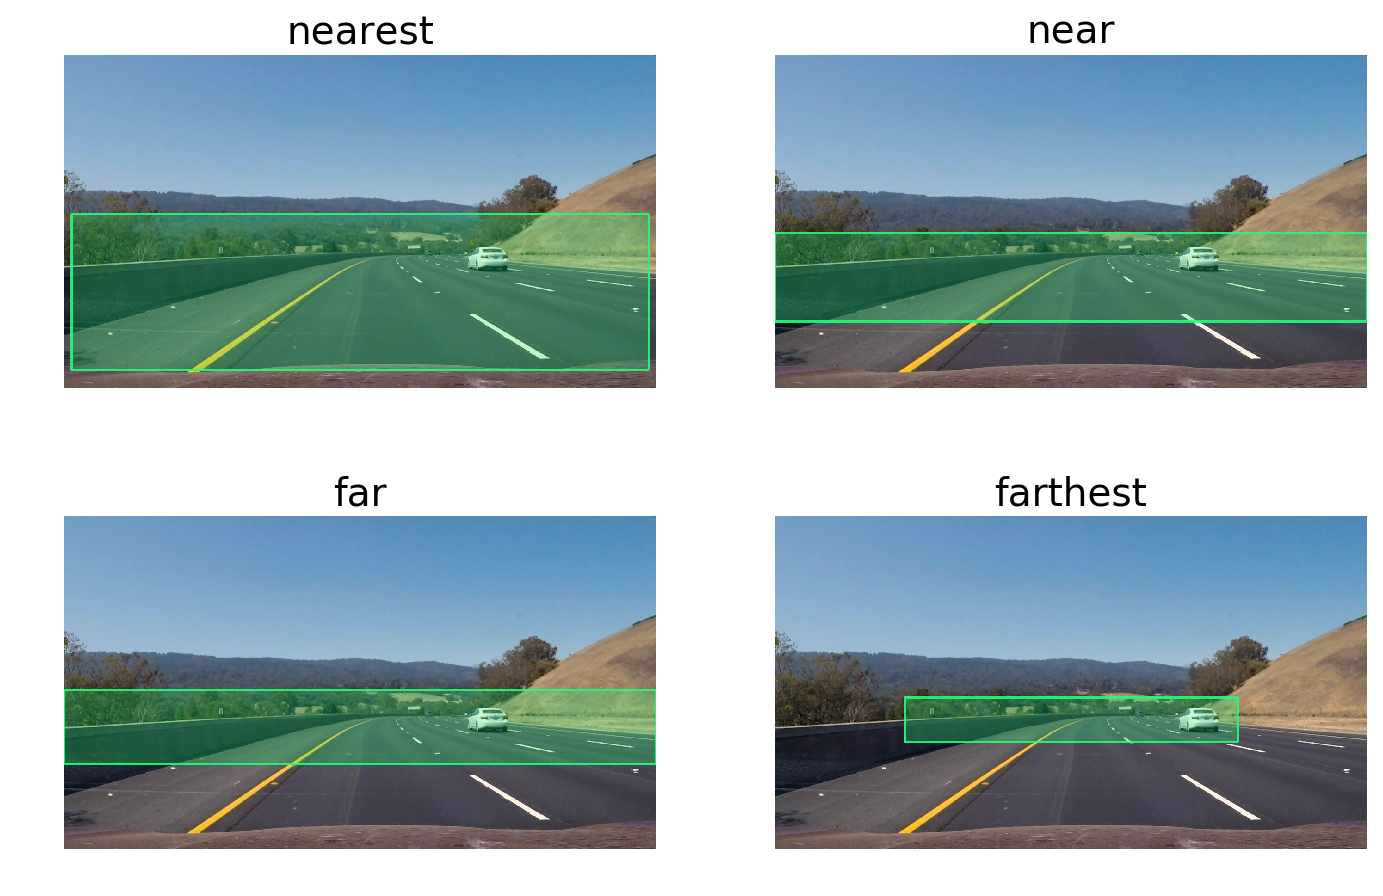

In [19]:
preview = import_image('./test_images/test3.jpg')

plt.subplots(2, 2, figsize=(12, 8), dpi=140)
i = 0

for name, area_of_interest in search_areas.items():
    area_of_interest = [(tup[0] * cell_size, tup[1] * cell_size) for tup in area_of_interest]
    if i == 4:
        export_image = searcher.get_area_of_interest(preview, area_of_interest)
        save_image(export_image)
    i += 1
    plt.subplot(2, 2, i)
    plot_image(quick_rectangle(preview, area_of_interest, filled=True), title=name)

Obtain a grid search object from these parameters, that can then be used to search the input images. The grid search extracts the areas of interest from the input image and then scales it such that the dimensions match that of the training data.

In [20]:
searcher = GridSearch(search_windows, search_areas, analyser)

To see how well our sliding search works, we will use it on the set of test images supplied in the repository. Each time a vehicle is registered by the classifier, the respective window is plotted on the respective image:

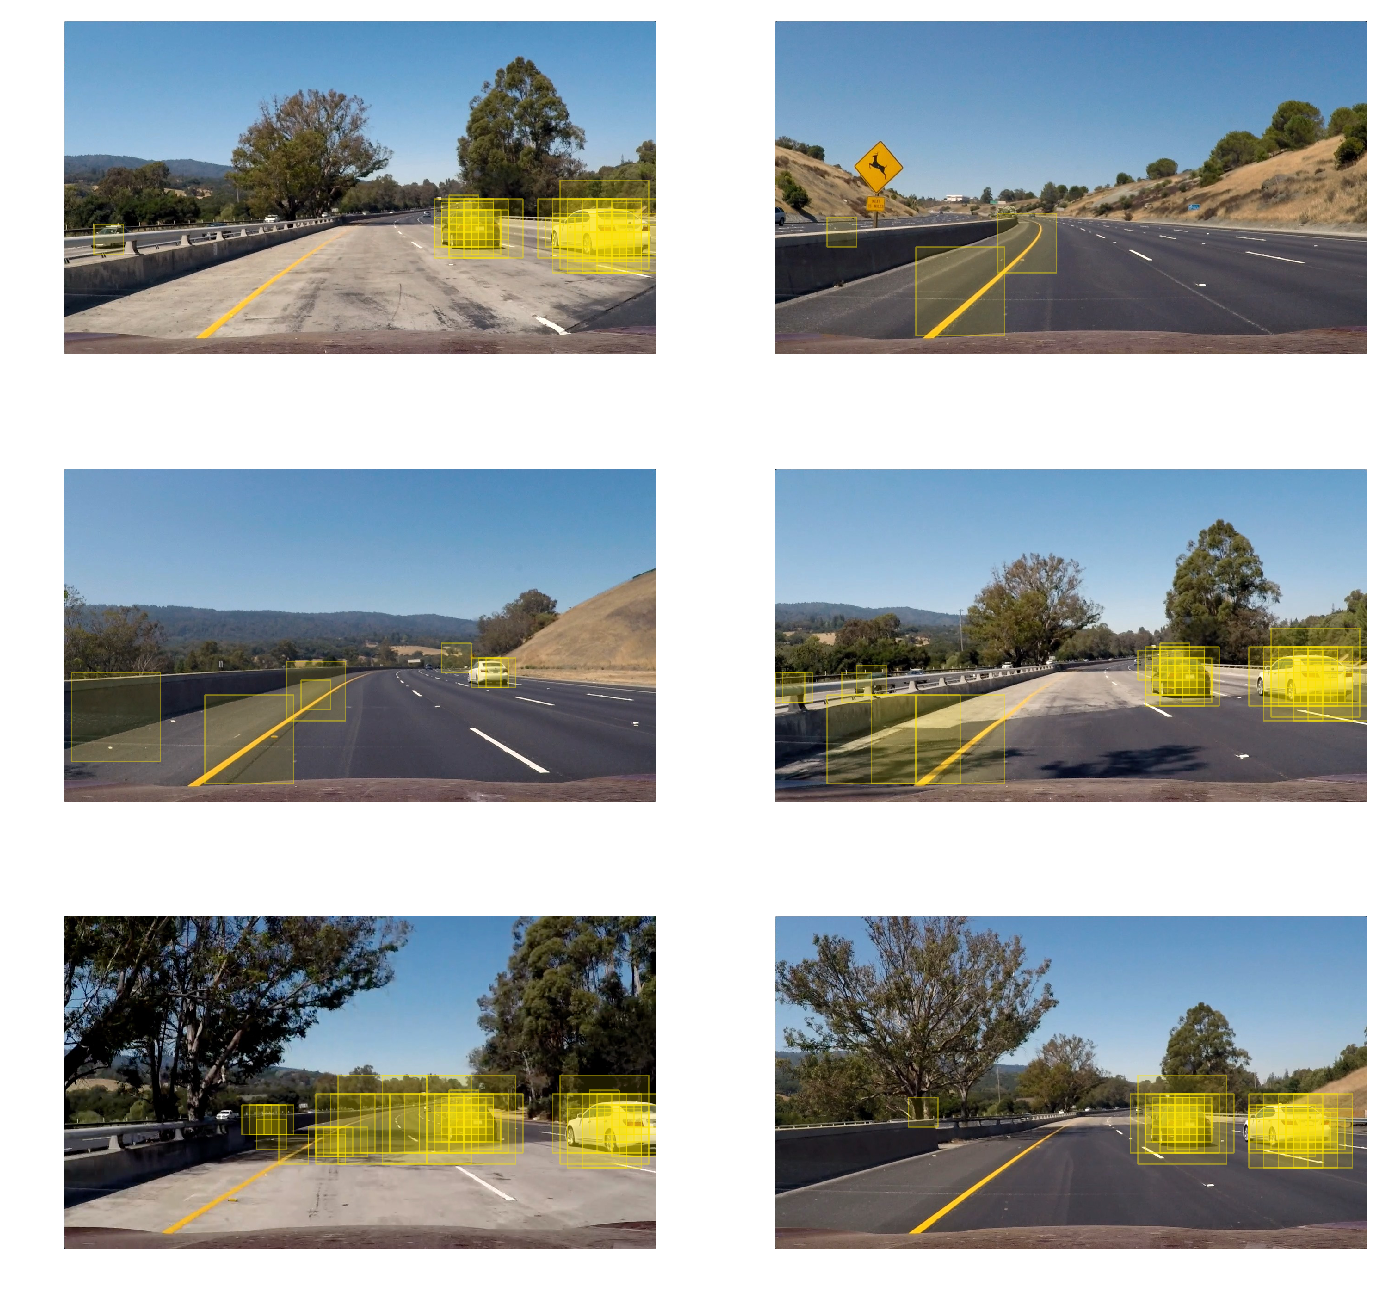

In [21]:
from glob import glob
test_image_files = glob('./test_images/test*.jpg')

subplot_rows = round(len(test_image_files)/2)
plt.subplots(subplot_rows, 2, figsize=(12, 12), dpi=140)
i = 0

for test_image_file in test_image_files:
    test_image = import_image(test_image_file)
    result = searcher.sliding_search(test_image, classifier)
    highlighted_img = searcher.highlight_windows(test_image, result)
    output_file_name = 'BasicSlidingWindowSearch_' + test_image_file.split('/')[-1].replace('.jpg', '')
    save_image(highlighted_img, name=output_file_name)
    i += 1
    plt.subplot(subplot_rows, 2, i)
    plot_image(highlighted_img)

From these results, we can see that the cars are detected repeatedly, while there are also some isolated spurious detections in some of the images. The classifier appears to have particular difficulties with shadows cast by trees. Especially the second last image appears to be difficult for our classifier. 

To remedy this we would need more training data of these kind of regions. While we could create this training data from our video, we would essentially be training on out "validation set", which means that our result would not generalise well.

## Filtering False Positives and Duplicates

As we have seen above, we always obtain multiple hits for a given car and there are regions where the classifier incorrectly detects cars. In order to filter out these duplicates and false positives, all image regions which registered vehicle predictions by the classifier are combined into a scalar field. This field is visualised with the heatmap below:

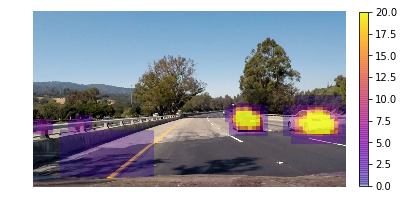

In [24]:
test_image = import_image('./test_images/test4.jpg')
result = searcher.sliding_search(test_image, classifier)
search_processor = SearchFilter(test_image, search_windows)
search_processor.update(test_image, result, threshold=8)

search_processor.visualise_hitmap()
plt.show()

The simplest way to remove false positives would be simply threshold the hit intensity. This means that any regions with less than multiple overlapping vehicle classifications are excluded. 

This works in principle, but as was seen above, the shadows register so many hits, that a filter strong enough to remove these results would also filter out genuine car detections. Instead, a second step is introduced, where a very high intensity ov overlapping windows is detected (in excess of 12). This very small region is then grown with `cv2.dilate` to create a search area where we now look for the boundary of the lower intensity region. This approach is significantly more robust. 

Once the results are filtered, the individual, discontinuous regions need to be identified.  For this we use **`scipy.ndimage.measurements.label()`** which allocates each pixel in a given region a region number, allowing us to draw rectangles around each of them.

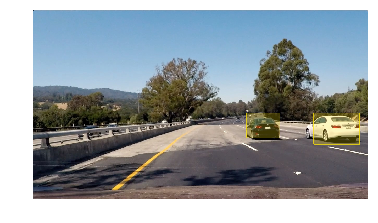

In [25]:
plot_image(search_processor.plot_detected_cars())

To get a better feeling for how the filter works we can test it on all of the test images:

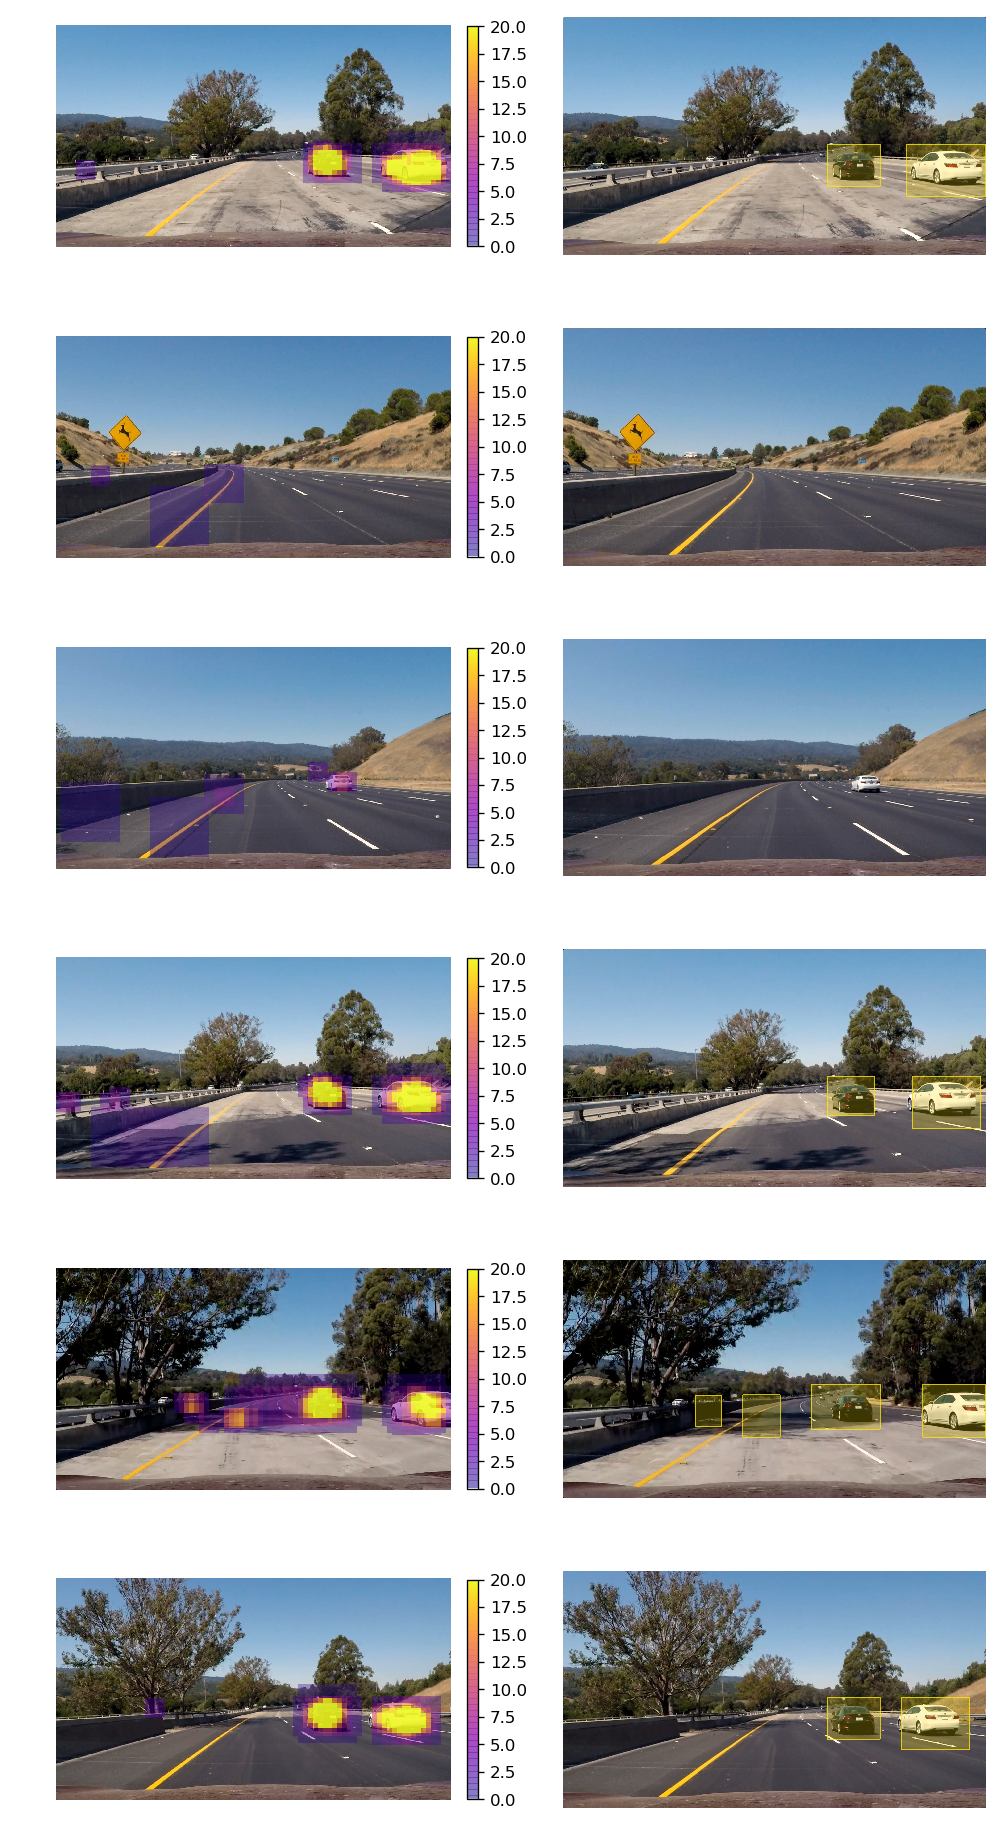

In [28]:
subplot_rows = round(len(test_image_files))
plt.subplots(subplot_rows, 2, figsize=(10, 20), dpi=120)
i = 0

for test_image_file in test_image_files:
    test_image = import_image(test_image_file)
    #Create a new object every loop to clear the hitmap from the previous image
    search_processor = SearchFilter(test_image, search_windows)
    #Run sliding window search
    result = searcher.sliding_search(test_image, classifier)
    #Filter search results
    search_processor.update(test_image, result, threshold=3)
    
    i += 1
    plt.subplot(subplot_rows, 2, (i*2 - 1))
    search_processor.visualise_hitmap()
    plt.subplot(subplot_rows, 2, (i*2))
    plot_image(search_processor.plot_detected_cars())
    

output_file_name = './output_images/TestImages_with_Heatmap_and_FilteredCars.jpg'
plt.savefig(output_file_name, bbox_inches='tight')

The results look good in most conditions, although there is still the issue with many false positives arising in the shadows of the trees and by desensitising the model to these false positives, the car in the distance (image 3) is not detected.

For images in sequence, we can address this by interpolating over consecutive frames. Using past detection to influence the current result.

# Processing Video

In order to get a more steady result and to filter out more spurious detections, the heatmap from the previous frame is carried over to the next. This is done in such a way that previous detections almost completely lose their influence after a second.

Here we define a small function that detects the cars in an image and returns the annotated image.

In [ ]:
def find_cars(image, search_filter, searcher, classifier):
    """Function to identify and annotate cars in an input image."""
    sliding_search_result = searcher.sliding_search(image, classifier)
    search_filter.update(image, sliding_search_result, threshold=3)
    return search_filter.plot_detected_cars()

The pipeline developed up to this stage can now be tested on the short video clip to check how it works on time series images:

In [ ]:
import imageio

video_name = 'project_video'
reader = imageio.get_reader(video_name + '.mp4')
fps = reader.get_meta_data()['fps']

video_output = video_name + '_annotated' + '.mp4'
writer = imageio.get_writer(video_output, fps=fps)

search_processor = SearchFilter(test_image, search_windows)

start = time.time()
i = 0

for image in reader:
    if i > 30 and i < 41:
        save_image(image, name=('sequence_' + str(i)))
    img_result = find_cars(image,
                           search_processor,
                           searcher,
                           classifier)
    writer.append_data(img_result.astype(np.dtype('uint8')))
    i += 1
print('Processing the video with', len(reader), 'frames took', round(time.time() - start, 2), 'seconds.')
writer.close()

The video file with the result can be found [here](./project_video_annotated.mp4).

# Discussion

The resulting image detection pipeline works reasonably well, although there are still false positive detections and difficulties detecting cars in the distance. The influence of the interpolation between frames can also be seen, since we are only using past and present data, the bounding box always appears to be lagging behind the motion of the car slightly. Sometimes the classifier also detects cars in the opposite lane, but this is behaviour that should be expected, since it is detecting what it was supposed to.

The biggest weakness for this approach is the classifier.  It is a product of many tradeoffs to reduce the computational cost and yet, the accuracy is not really high enough for reliable use.  It may be possible to increase the performance with more and more varied training data, but it is probably best to embrace a more modern object detection method on the basis of neural networks (YOLO or Single Shot Detection SSD).